# 偽のデータを作成

In [1]:
from numpy import *
Nobs = 20
x_true = random.uniform(0,10, size=Nobs)
y_true = random.uniform(-1,1, size=Nobs)
alpha_true = 0.5
beta_x_true = 1.0
beta_y_true = 10.0
eps_true = 0.5
z_true = alpha_true + beta_x_true*x_true + beta_y_true*y_true
z_obs = z_true + random.normal(0, eps_true, size=Nobs)

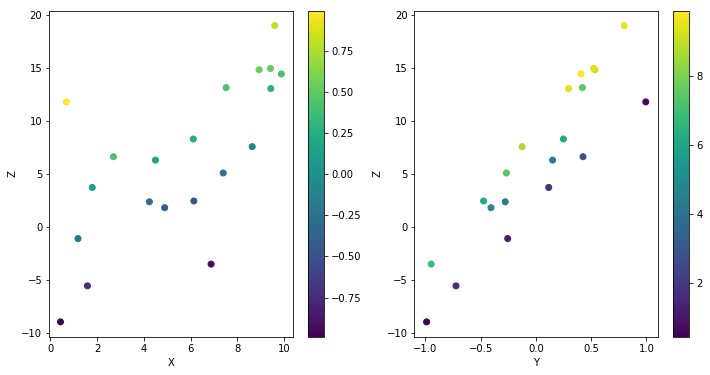

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x_true, z_obs, c=y_true, marker='o')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Z')
plt.subplot(1,2,2)
plt.scatter(y_true, z_obs, c=x_true, marker='o')
plt.colorbar()
plt.xlabel('Y')
plt.ylabel('Z')

PyStanと同様でヒラリカルな方法でモデルを作成する。

In [3]:
import pymc
# define the parameters with their associated priors
alpha = pymc.Uniform('alpha', -100,100, value=median(z_obs))
betax = pymc.Uniform('betax', -100,100, value=std(z_obs)/std(x_true))
betay = pymc.Uniform('betay', -100,100, value=std(z_obs)/std(y_true))
eps = pymc.Uniform('eps', 0, 100, value=0.01)

# Now define the model
@pymc.deterministic
def model(alpha=alpha, betax=betax, betay=betay, x=x_true, y=y_true):
    return alpha + betax*x + betay*y

# pymc parametrizes the width of the normal distribution by tau=1/sigma**2
@pymc.deterministic
def tau(eps=eps):
    return power(eps, -2)

# Lastly relate the model/parameters to the data
data = pymc.Normal('data', mu=model, tau=tau, value=z_obs, observed=True)

In [4]:
sampler = pymc.MCMC([alpha,betax,betay,eps,model,tau,z_obs,x_true,y_true])
sampler.use_step_method(pymc.AdaptiveMetropolis, [alpha,betax,betay,eps],
                        scales={alpha:0.1, betax:0.1, betay:1.0, eps:0.1})
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.4 sec

Plotting alpha
Plotting betax
Plotting eps
Plotting betay
Plotting tau


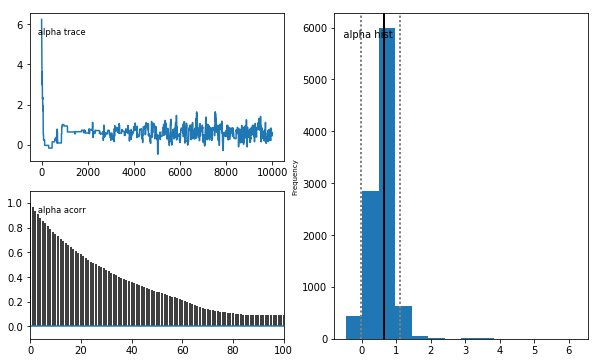

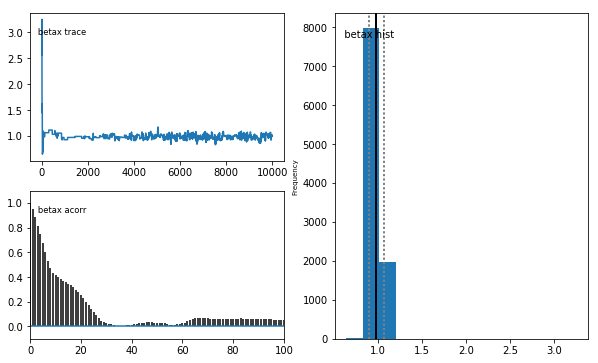

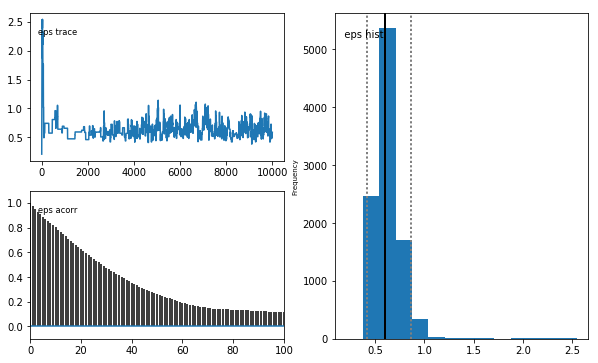

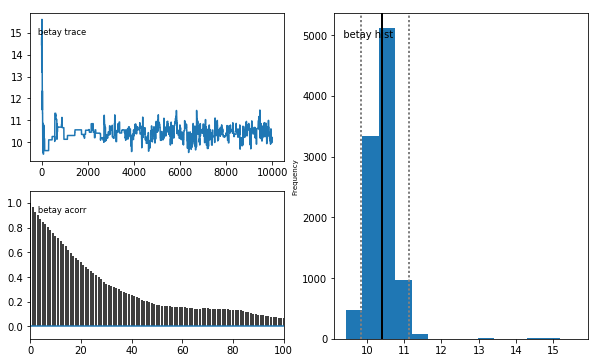

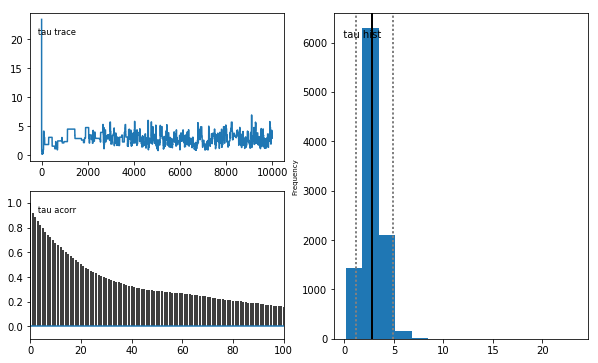

In [5]:
pymc.Matplot.plot(sampler)

In [6]:
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.6 sec

In [7]:
m_alpha = median(alpha.trace())
m_betax = median(betax.trace())
m_betay = median(betay.trace())
m_eps = median(eps.trace())

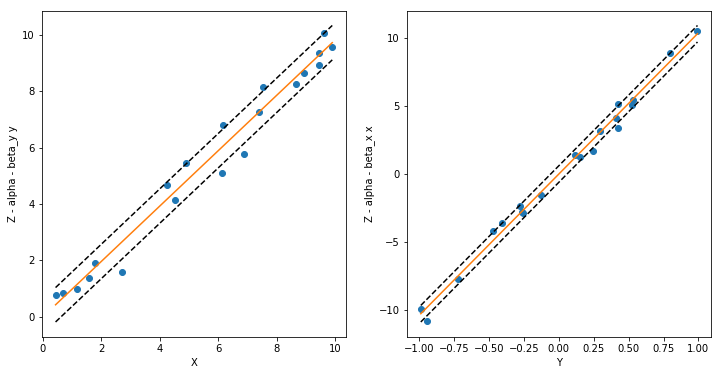

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_true, z_obs-m_alpha-m_betay*y_true, 'o')
plt.xlabel('X')
plt.ylabel('Z - alpha - beta_y y')
# Now plot the model
xx = array([x_true.min(), x_true.max()])
plt.plot(xx, xx*m_betax)
plt.plot(xx, xx*m_betax + m_eps, '--', color='k')
plt.plot(xx, xx*m_betax - m_eps, '--', color='k')
plt.subplot(1,2,2)
plt.plot(y_true, z_obs-m_alpha-m_betax*x_true, 'o')
plt.xlabel('Y')
plt.ylabel('Z - alpha - beta_x x')
yy = array([y_true.min(), y_true.max()])
plt.plot(yy, yy*m_betay)
plt.plot(yy, yy*m_betay + m_eps, '--', color='k')
plt.plot(yy, yy*m_betay - m_eps, '--', color='k')

(10000, 4)


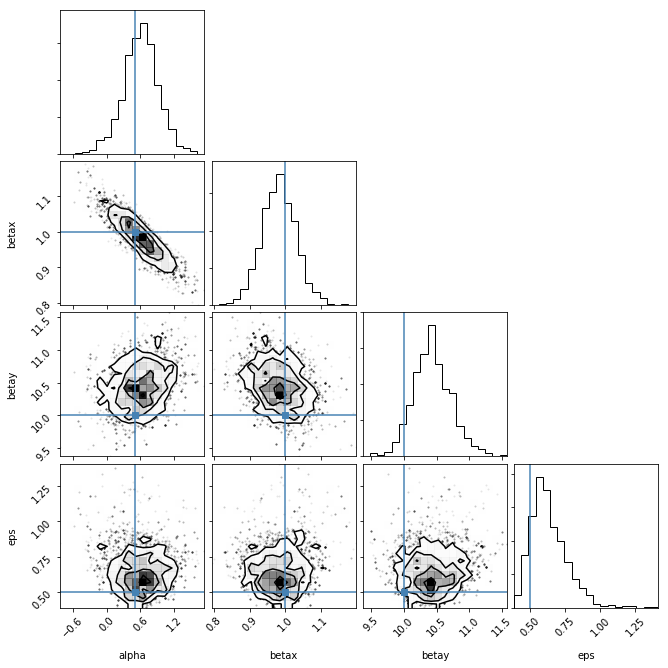

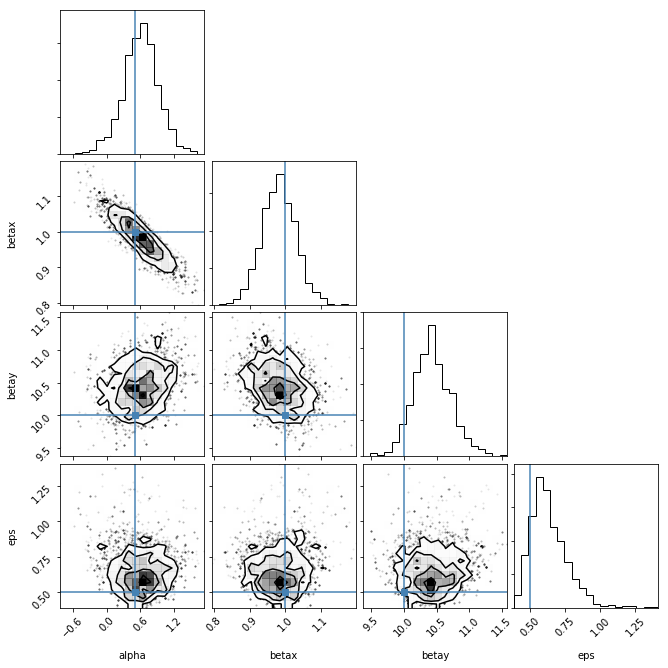

In [22]:
samples = array([alpha.trace(),betax.trace(),betay.trace(),eps.trace()]).T
print((samples.shape))
import triangle
triangle.corner(samples[:,:], labels=['alpha','betax','betay','eps'], truths=[alpha_true, beta_x_true, beta_y_true, eps_true])